# Flats
J. C. Runnoe, 2021

This Jupyter notebook includes information and code snippets useful for dealing with image combination using the V-band flats as an example. These notebooks have additional information that may prove useful:

<a href="https://github.com/mwcraig/ccd-reduction-and-photometry-guide/blob/80368509444a05b9bb783059c456a86bc5776735/notebooks/01-06-Image-combination.ipynb">01-06 Image Combination</a> <br>
<a href="https://github.com/mwcraig/ccd-reduction-and-photometry-guide/blob/master/notebooks/05-00-Flat-corrections.ipynb">05-00 Flat-corrections</a> <br>
<a href="https://github.com/mwcraig/ccd-reduction-and-photometry-guide/blob/master/notebooks/05-03-Calibrating-the-flats.ipynb">05-03 Calibrating-the-flats</a> <br>
<a href="https://github.com/mwcraig/ccd-reduction-and-photometry-guide/blob/master/notebooks/05-04-Combining-flats.ipynb">05-04 Combining-flats</a>

The CCDPROC combine function used in the notebooks above has sigma clipping included, you just need to specify the keywords. ASTROPY also has some tools that you can use, check out their function <a href="https://docs.astropy.org/en/stable/api/astropy.stats.sigma_clip.html">here</a>.



In [2]:
# import block
import numpy as np
from astropy.io import fits
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.visualization import hist
import ccdproc as ccdp
from matplotlib import rc
from datetime import datetime
from astropy.nddata import CCDData

phot_tutorial_dir = '/home/kyle/Homework/Astro8060/ccd-reduction-and-photometry-guide/notebooks'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

import warnings
warnings.filterwarnings('ignore')

In [3]:
# plotting defaults
# Use custom style for larger fonts and figures
#phot_tutorial_dir = '/Users/runnojc1/Dropbox/Research/teaching/F2021/ASTR8060/work/reductions/example/notebooks'
plt.style.use(phot_tutorial_dir+'/guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=12)
rc('axes', grid=True)

In [4]:
# define directories
data_dir = '/home/kyle/Homework/Astro8060/NoBackupImages/raw/'
reduced_dir = '/home/kyle/Homework/Astro8060/NoBackupImages/reduced/'

In [5]:
# define the trimsec for python (i.e. not for the fits header)
r0 = 0
r1 = 2048
c0 = 54
c1 = 2101

## 1. Load up the V-band flats

Ideally, these should be overscan subtracted, trimmed, and bias corrected. But for the purposes of exploring today, you can use the raw flats. Why is this true?

If you have not already done so, you will need to update the headers for these files, similar to what you did for the bias frames.

To check that you have read the V-band in flats in successfully, plot them all.

In [6]:
# get V-band filenames
fileNums = np.arange(43,50) #Will exclude last number

#Get file names
flat_files = [reduced_dir+'a'+str(i).zfill(3)+'.fits' for i in fileNums]

# read in the hdus, hdrs, data
# use list comprehension
HDUs = [fits.open(file) for file in flat_files]
HDRs = [hdu[0].header for hdu in HDUs]
#FLAT_DATA = [hdu[0].data for hdu in HDUs]


# loop over the hdus or hdrs
# add IMAGETYP, BIASSEC, TRIMSEC, FILTER
# (I used 'skyflat' for my image type, if you use something else you'll need edit later code)
# write out the hdu to the original fits file
for i in range(np.size(HDUs)):
    HDRs[i]['IMAGETYP']='skyflat'
    HDRs[i]['FILTER']='V'
    HDRs[i]['BIASSEC']='[1:2048, 2102:2200]'
    HDRs[i]['TRIMSEC']='[1:2048, 54:2101]'
    
    HDUs[i].writeto(flat_files[i],overwrite=True)


del HDUs
del HDRs

In [7]:
# put all of the fits files in an image collection
# this is just CCDPROC's way of storing information for groups of fits images
imgs = ccdp.ImageFileCollection(reduced_dir,glob_include='a*.fits') 

# if you've done the overscan, trim, and bias subtraction, use only those files
# imgs = ccdp.ImageFileCollection(reduced_dir,glob_include='*otz.fits') # just read in the bias-subtracted images

In [8]:
# select all the flats
# you won't need these lines now, but they're handy
flat_files = imgs.files_filtered(imagetyp='skyflat',include_path=True)
bands = imgs.filter(imagetyp='skyflat').summary['filter'].data.data # makes a set of all filters
band = set(imgs.filter(imagetyp='skyflat').summary['filter'].data.data) # unique filter names

# isolate the v-band flats
# you do need this
v_files = imgs.files_filtered(imagetyp='skyflat',filter='V',include_path=True)

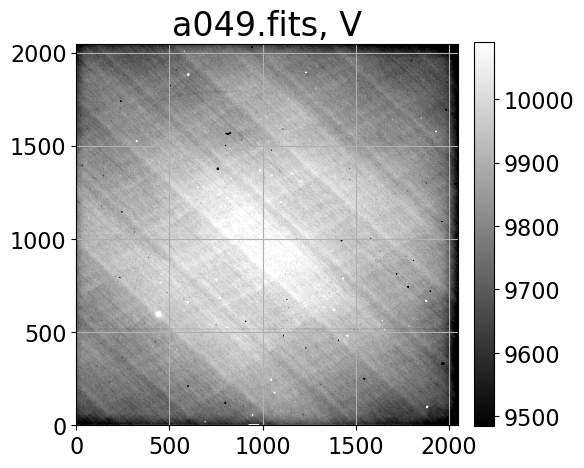

In [9]:
# here is how you would plot one flat
# you should edit this to do all of them in a loop
flat = CCDData.read(v_files[0],unit='adu') # this is how CCDPROC reads in one fits image

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
show_image(flat.data[:,c0:c1], cmap='gray', ax=ax, fig=fig)
ax.set_title(v_files[i][-9:]+', V') # index filename to exclude long directory
plt.tight_layout()
plt.show()

## 2. Does the level of the V-band flats change with time?

Make a plot of the average counts in the V-band flats as a function of time. Based on what you find, do you think scaling will be important for calculating a V-band master flat?

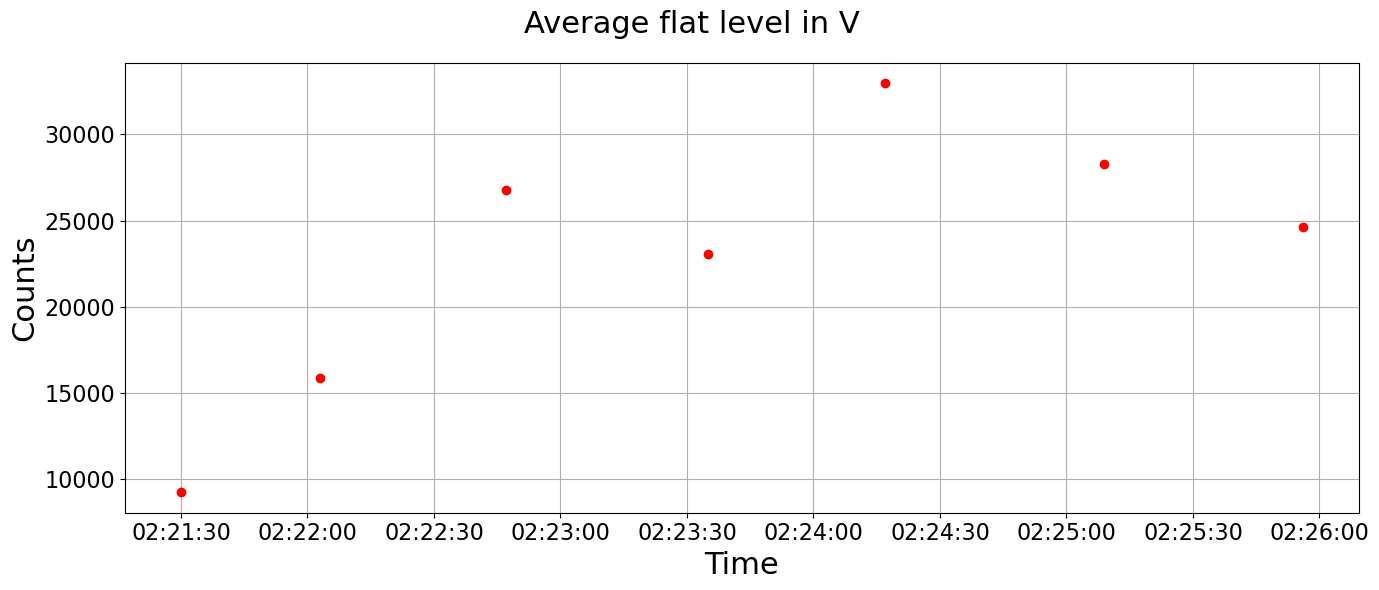

In [10]:
# get obs times, try looking for the 'date-obs' header keyword
times = imgs.filter(imagetyp='skyflat',filter='V').summary['date-obs'].data.data 
flat_times = [datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.%f') for time in times] # these are nicely formatted for plotting

# get the average level in each frame
# use list comprehension to make an array of the V-band flat mean values
# it should have the same length as the flat_tiles variable above
# here are the steps to do this for only the first flat
#Files are in v_files
flats = [CCDData.read(f,unit='adu') for f in v_files] # this is CCDPROC's way of reading in fits files
flat_mean = [np.mean(f.data) for f in flats]


# make the plot
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(flat_times,flat_mean,'red',marker='o',ls='')
ax.set_xlabel(r'Time',fontsize=22)
ax.set_ylabel(r'Counts',fontsize=22)
fig.suptitle('Average flat level in V', fontsize=22)
fig.tight_layout()
plt.show()

## 3. Combine the V-band flats
Combine the V-band flats using:
 - a straight mean combine
 - a straight median combine
 
Compare these to each other and to the individual frames. What do you notice?

In [11]:
# you can do this with CCDPROC's combine function:
flat_mn_ccdp = ccdp.combine(v_files,method='average',unit='adu',sigma_clip=False)
flat_md_ccdp = ccdp.combine(v_files,method='median',unit='adu',sigma_clip=False)

# or you can read in the data and do the combine yourself
flats   = [CCDData.read(file_name,unit='adu').data for file_name in v_files]
flat_mn = np.mean(flats,axis=0)   # is that the right number for axis?
single_flat = CCDData.read(v_files[-1],unit='adu').data


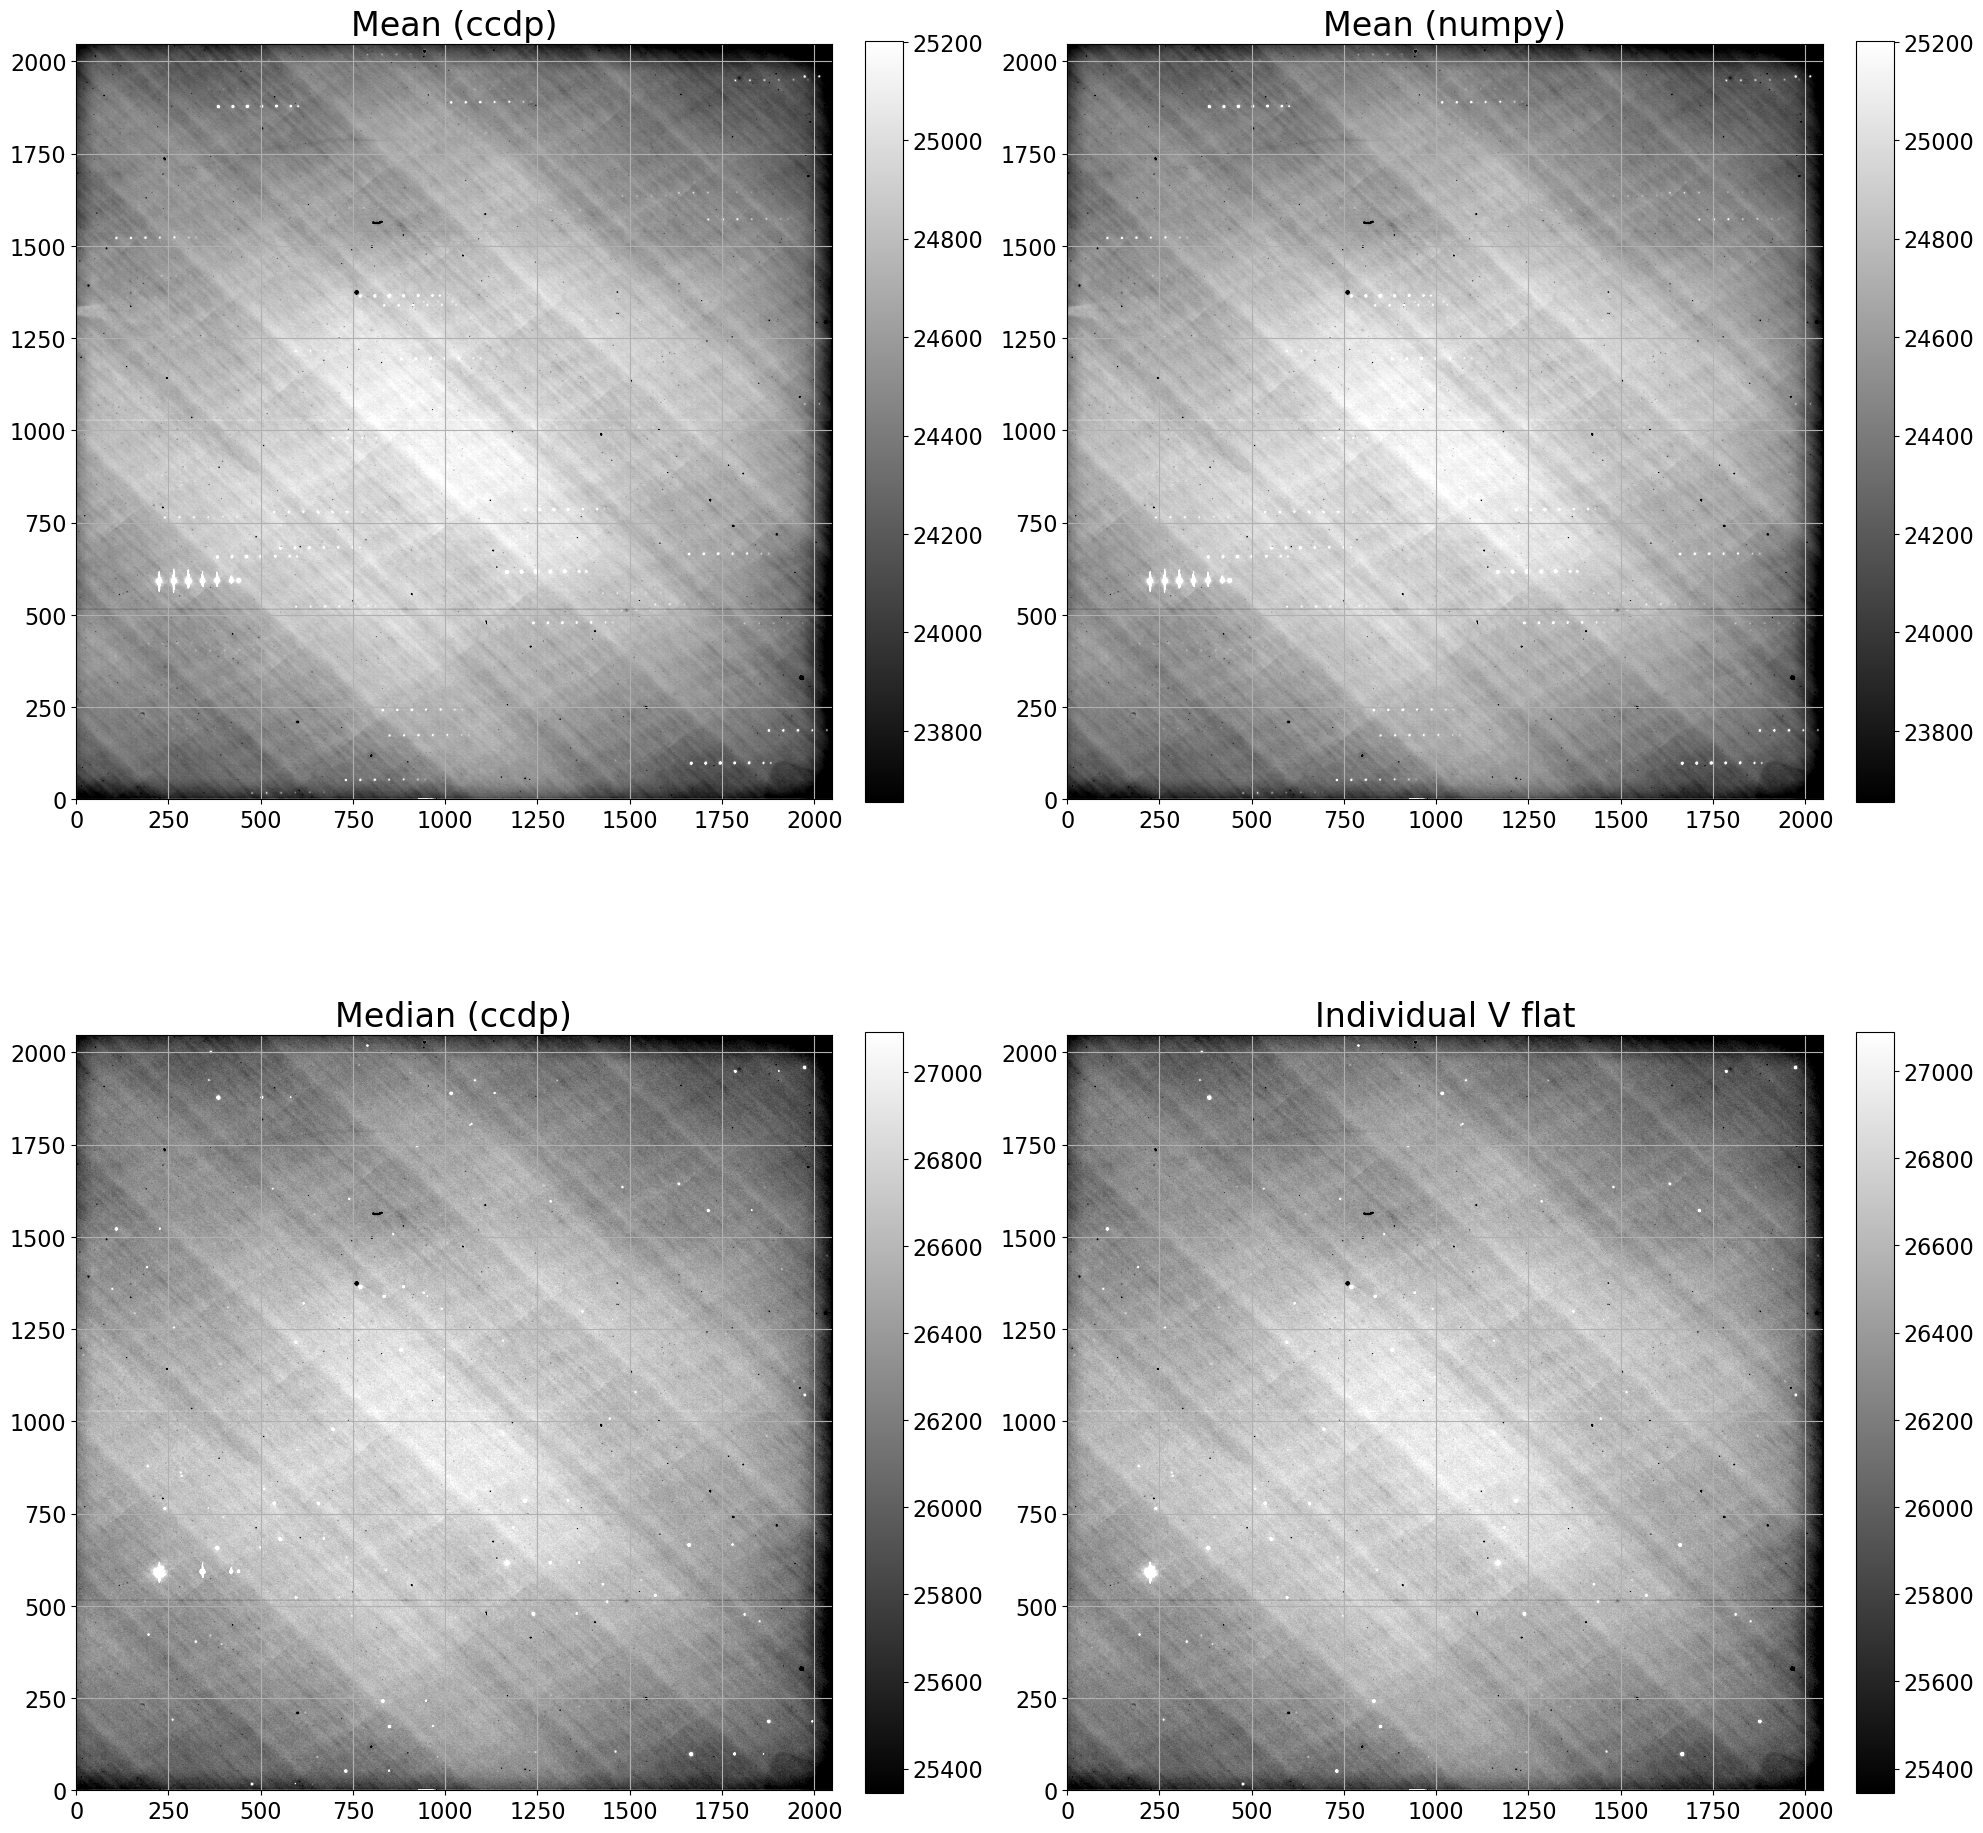

In [12]:
# now plot them
# the titles are suggestions for flats you may want to compare
# you will need to edit the input data arrays, these are mostly placeholders
# try taking the the ccdp-numpy mean flats to see if they are different
fig, (ax1,ax2) = plt.subplots(2, 2, figsize=(20, 20))
show_image(flat_mn_ccdp.data[:,c0:c1], cmap='gray', ax=ax1[0], fig=fig)
ax1[0].set_title('Mean (ccdp)')
show_image(flat_mn[:,c0:c1], cmap='gray', ax=ax1[1], fig=fig)
ax1[1].set_title('Mean (numpy)')
show_image(flat_md_ccdp.data[:,c0:c1], cmap='gray', ax=ax2[0], fig=fig)
ax2[0].set_title('Median (ccdp)')
show_image(single_flat[:,c0:c1], cmap='gray', ax=ax2[1], fig=fig)
ax2[1].set_title('Individual V flat')
plt.tight_layout()
plt.show()

## 4. Combine the V-band flats with scaling

Do the flats need to be scaled when you combine them? If so, use the median to scale each flat so its values are centered around 1. Then combine them. How is this different from what you did in #3? Try a mean and a median combine this way.

In [13]:
# define your own functions that tell CCDPROC how to scale your images
def inv_median(x):
    return 1./np.median(x)

def inv_mean(x):
    return 1./np.mean(x)

def inv_mode(x):
    return 1./stats.mode(x,axis=None)[0][0]

In [14]:
# you can do this with CCDPROC's combine function:
# this will do a mean combine with mean scaling
flat_md_md_ccdp = ccdp.combine(v_files,method='median',scale=inv_median,unit='adu',sigma_clip=False)

# or you can read in the data and do the combine yourself
flats  = [CCDData.read(file_name,unit='adu').data for file_name in v_files]
scales = np.median(flats,axis=(1,2)) # calculate a single mean value for each flat
scale_images = np.ones_like(flats)*scales[:,np.newaxis,np.newaxis] # make an images shaped like the flats, where each pixel has the identical scale value in it
scaled_flats = flats/scale_images

flat_md_md = np.median(scaled_flats,axis=0)

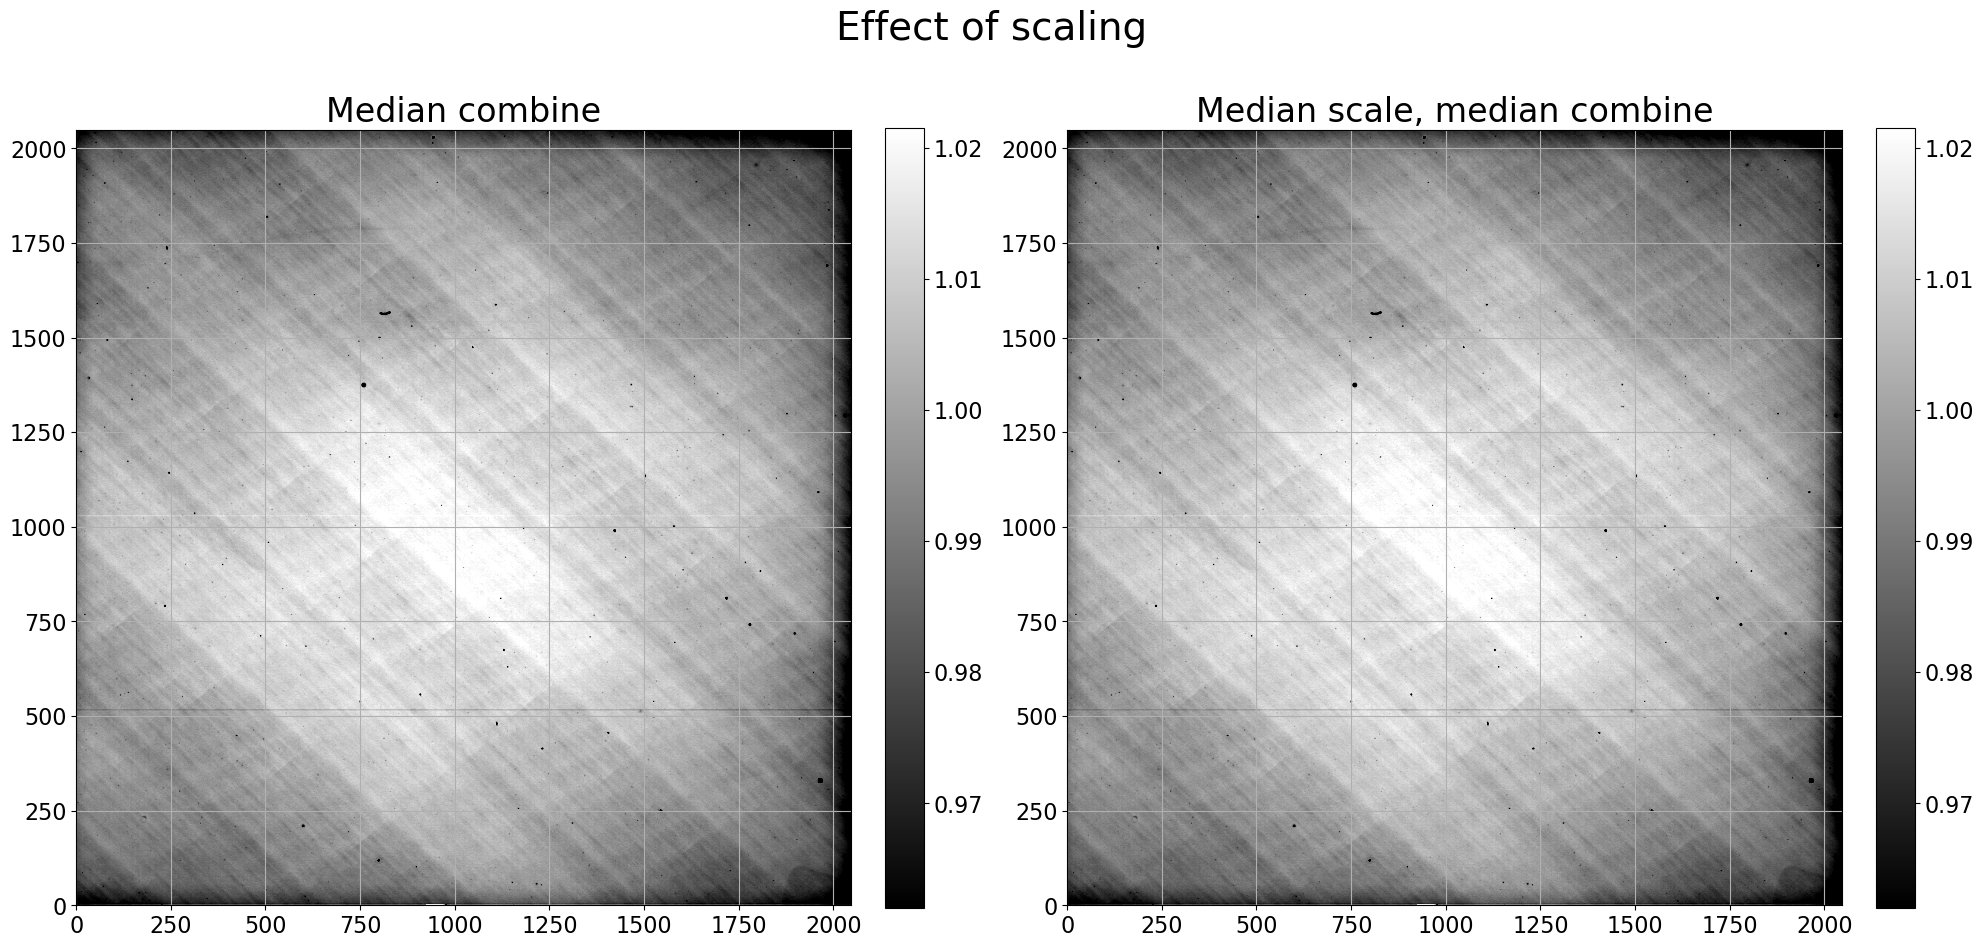

In [15]:
# make plots to show what you're doing
# now plot them
# the titles are suggestions for flats you may want to compare
# you will need to edit the input data arrays, these are mostly placeholders
# try taking the the ccdp-numpy mean flats to see if they are different
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title('Median combine')
show_image(flat_md_md[:,c0:c1], cmap='gray', ax=ax[0], fig=fig)
ax[1].set_title('Median scale, median combine')
show_image(flat_md_md[:,c0:c1], cmap='gray', ax=ax[1], fig=fig)
fig.suptitle('Effect of scaling',size=28)
plt.tight_layout()
plt.show()

## 5. Combine the V-band flats with scaling and sigma clipping

Try combining the flats with sigma clipping. You can use the CCDPROC combine task, or implement your own. What’s a good level for sigma clipping for these frames?

Use mean combine, and compare sigma-clipped mean combined flats versus a straight mean without sigma clipping to see how well it is working.

In [16]:
# try doing this yourself
# I recommend looking at the example notebooks from the photometry tutorial
# or see the tutorial about astropy's sigma clipping

# also, here is the combine documentation
# so you can see what inputs may be needed for sigma clipping
print(ccdp.combine.__doc__)


    Convenience function for combining multiple images.

    Parameters
    -----------
    img_list : `numpy.ndarray`, list or str
        A list of fits filenames or `~astropy.nddata.CCDData` objects that will be
        combined together. Or a string of fits filenames separated by comma
        ",".

    output_file : str or None, optional
        Optional output fits file-name to which the final output can be
        directly written.
        Default is ``None``.

    method : str, optional
        Method to combine images:

        - ``'average'`` : To combine by calculating the average.
        - ``'median'`` : To combine by calculating the median.
        - ``'sum'`` : To combine by calculating the sum.

        Default is ``'average'``.

    weights : `numpy.ndarray` or None, optional
        Weights to be used when combining images.
        An array with the weight values. The dimensions should match the
        the dimensions of the data arrays being combined.
        Defaul

## 5.1 Where does CCDPROC store files?

In the course of your data reduction, you may want to find the Python code files for CCDPROC. For example, if you want to determine how the CCDPROC sigma clipping algorithm is implemented. How does the CCDPROC combiner do sigma clipping? How does it use the weights that you give it?

In [17]:
import ccdproc as ccdp
print(ccdp.__file__)

/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/ccdproc/__init__.py
